# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

A more complete and self-contained version of this TFOP pipeline will soon be available on [the author's github](https://github.com/waalkesw).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [3]:
%matplotlib inline
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve
from astropy.modeling import models, fitting, optimizers, statistic, custom_model
import batman
from ldtk import (LDPSetCreator,BoxcarFilter)
from ldtk.filters import kepler
import corner as triangle

In [4]:
def Limb_Dark(Teff = 3300,
              Terr = 100,
              log_g = 4.4,
              g_err = 0.1,
              met = 0.0,
              met_err = 0.01,
              filters = [kepler]):
        
    sc = LDPSetCreator(filters=filters,
                   teff=[Teff,Terr],
                   logg=[log_g, g_err],
                   z=[met, met_err])
    
    ps = sc.create_profiles(nsamples=500)
    qc,qe = ps.coeffs_qd(do_mc=True)
    
    LD_coeff = qc
    
    return LD_coeff

In [5]:
def BATMAN(P,
           Rp,
           t0,
           inc,
           A,
           LD,
           t = None,
           Baseline = 1.0):
                    
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in hours
    params.rp = Rp                       # planet radius (in units of stellar radii)
    params.a = A                         # semi-major axis (in units of stellar radii)
    params.inc = inc                     # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = LD                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    #m = batman.TransitModel(params, t, exp_time=60.0, supersample_factor = 12)   # initializes model
    m = batman.TransitModel(params, t)   # initializes model
    
    flux = m.light_curve(params)*Baseline   # calculates light curve
    
    return flux

In [83]:
def lnprior(LC1,LC2,LC3,LC4,LC5,
            theta,
            planet_a):
    
    A1,A2,A3,A4,A5,t1,t2,t3,t4,t5,rp,a,i = theta
        
    i_min = np.arccos(1/a)*180/np.pi

    if (0.0 <= rp <= 1.0) and (2 <= a <= 200) and (i_min <= i <= 90.0):
        
        return 0.0
    
    return -np.inf

In [85]:
def lnprob(theta,
           LC1,LC2,LC3,LC4,LC5,
           planet_period,
           LD,
           planet_a,
           plot = False):
        
    # Pull out some model parameters
    A1,A2,A3,A4,A5,t1,t2,t3,t4,t5,rp,a,i = theta   
    
    # First we want a model to perform the lnprob calculation with.
    model1 = A1*BATMAN(planet_period, rp, t1, i, a, LD, t = LC1.time)
    model2 = A2*BATMAN(planet_period, rp, t2, i, a, LD, t = LC2.time)
    model3 = A3*BATMAN(planet_period, rp, t3, i, a, LD, t = LC3.time)
    model4 = A4*BATMAN(planet_period, rp, t4, i, a, LD, t = LC4.time)
    model5 = A5*BATMAN(planet_period, rp, t5, i, a, LD, t = LC5.time)
        
    # We need to make sure the uniform priors are accounted for:
    ln_prior = lnprior(LC1,LC2,LC3,LC4,LC5, theta, planet_a)
    
    # This is a Gaussian likelihood, for independent data points
    
    chisq1 = np.sum((LC1.flux - model1)**2/(LC1.flux_err)**2)
    ln_like1 = (np.sum(1/np.sqrt(2*np.pi*(LC1.flux_err))) - 0.5*chisq1)
    
    chisq2 = np.sum((LC2.flux - model2)**2/(LC2.flux_err)**2)
    ln_like2 = (np.sum(1/np.sqrt(2*np.pi*(LC2.flux_err))) - 0.5*chisq2)
    
    chisq3 = np.sum((LC3.flux - model3)**2/(LC3.flux_err)**2)
    ln_like3 = (np.sum(1/np.sqrt(2*np.pi*(LC3.flux_err))) - 0.5*chisq3)
    
    chisq4 = np.sum((LC4.flux - model4)**2/(LC4.flux_err)**2)
    ln_like4 = (np.sum(1/np.sqrt(2*np.pi*(LC4.flux_err))) - 0.5*chisq4)
    
    chisq5 = np.sum((LC5.flux - model5)**2/(LC5.flux_err)**2)
    ln_like5 = (np.sum(1/np.sqrt(2*np.pi*(LC5.flux_err))) - 0.5*chisq5)
    
    return ln_prior+ln_like1+ln_like2+ln_like3+ln_like4+ln_like5

In [8]:
def corner(samples):
        
    labels = ['Rp/R*','a/R*','i (deg)']
    Samples = samples[-3:].T
    
    np.random.seed(41)
    figure = triangle.corner(Samples,labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
    plt.savefig('Figs/TOI_{:.0f}_Corner.pdf'.format(toi))

In [109]:
def light_curve(lc,
                best_parameters,
                sampler,
                static_params,
                nsteps,
                tic_id,
                obs='first'):
    
    ########################
    # Read in the parameters
    ########################
    
    planet_radius, planet_period, planet_a, planet_i, toi = static_params
    hires_times = np.linspace(lc.time[0],lc.time[-1],1000)
    C1_best, rp_best, t_0_best, a_best, i_best = best_parameters
    burnin = int(0.25*nsteps)
    
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    A1_sam,A2_sam,A3_sam,A4_sam,A5_sam,t01_sam,t02_sam,t03_sam,t04_sam,t05_sam,Rp,A,Inc = samples
    
    if obs == 'first':
        C1 = A1_sam
        t0 = t01_sam
        
    if obs == 'second':
        C1 = A2_sam
        t0 = t02_sam
        
    if obs == 'third':
        C1 = A3_sam
        t0 = t03_sam
    
    if obs == 'fourth':
        C1 = A4_sam
        t0 = t04_sam
        
    if obs == 'fifth':
        C1 = A5_sam
        t0 = t05_sam
    ########################################################################
    # Calculate the model with the best-fit MCMC params, calculate residuals
    ########################################################################
    
    model_to_plot = BATMAN(planet_period, rp_best, t_0_best, i_best, a_best, LD, t = hires_times)
    best_model = C1_best*BATMAN(planet_period, rp_best, t_0_best,
                                i_best, a_best, LD, t = lc.time)
    residual = (lc.flux-best_model)/lc.flux_err
    
    #########################
    # Plot the best-fit model
    #########################
            
    f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                               figsize=(10,7),sharex=True)
    
    a0.set_title('Modeled LCO Light Curve for TOI {}'.format(toi),fontsize=20)
    a0.errorbar((lc.time-t_0_best)*24,lc.flux/(C1_best),
                yerr=lc.flux_err/C1_best,
                fmt='o',alpha=0.5,color='royalblue',markersize='5')
    a0.plot((hires_times-t_0_best)*24,model_to_plot,label='Best-Fit Model',color='k',zorder=100)
    a0.set_ylabel('Normalized Flux',fontsize=18)
    #a0.set_xlim(-2.5,2.5)
    a0.set_ylim(0.985,1.01)
    a0.minorticks_on()
    a0.legend(loc='lower right')
    a0.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
    
    #########################################
    # Plot 200 random models from the samples
    #########################################
    
    for j in range(0,200,1):
        i = np.random.randint(low=0,high=(nsteps-burnin)*100)
        sigma_model = BATMAN(P = planet_period, Rp = Rp[i], t0 = t0[i],
                             inc = Inc[i], A = A[i], LD = LD, t = hires_times)
        a0.plot((hires_times-t_0_best)*24,sigma_model,color='red',alpha = 0.1,
                linewidth=0.8,zorder=-1000,label='Random Samples')
        
    ####################
    # Plot the residuals
    ####################

    a1.scatter((lc.time-t_0_best)*24,residual,color='royalblue',alpha=0.5)
    a1.axhline(0,color='k')
    a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
    a1.minorticks_on()
    a1.set_ylabel(r'Residuals ($\rm{\sigma}$)',fontsize=15)
    a1.set_xlabel('Time from Mid-Transit (hr)')
    a1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
        
    plt.xlabel('BJD TDB',fontsize=16)
    plt.savefig('Figs/TOI_{:.0f}_modeled'.format(toi)+obs+'.pdf')

In [87]:
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')

TIC_ID = params['TIC ID']
TOI = params['TOI']

In [88]:
index = int(100)

tic_id = int(TIC_ID[index])
toi = TOI[index]
observatory = 'LCO 1-m'
print('TIC {:.0f}'.format(tic_id))
print('TOI {:.2f}'.format(toi))

TIC 305048087
TOI 237.01


In [89]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
epoch = Epoch
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
depth = 1.0-ppm_depth/1e6

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

In [15]:
data_all = lcf = lk.search_lightcurvefile('TIC {}'.format(int(tic_id))).download_all()
LC_all = lcf[0].PDCSAP_FLUX.remove_outliers(sigma=10)

Anticipated mid-transit time = 1355.249810
Anticipated mid-transit time = 1360.685896
Anticipated mid-transit time = 1366.121982
Anticipated mid-transit time = 1371.558068
Anticipated mid-transit time = 1376.994154


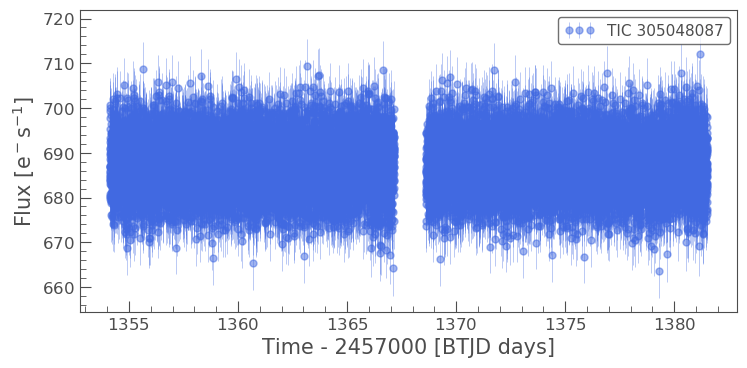

In [90]:
LC_all.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + (epoch-3*planet_period))
for i in range(len(n)):
    if (mid_transit_times[i] >= LC_all.time[0]):
        if (mid_transit_times[i] <= LC_all.time[-1]):
            
            expected_t0 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0))
            
plt.savefig('Figs/TOI_{:.0f}_TESSDat'.format(toi)+'.pdf')

In [19]:
expected_t0_1 = 1355.249810
expected_t0_2 = 1360.685896
expected_t0_3 = 1366.121982
expected_t0_4 = 1371.558068
expected_t0_5 = 1376.994154

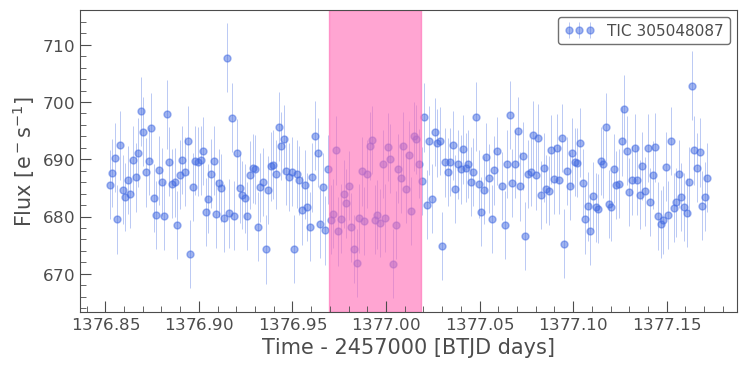

In [61]:
lc = LC_all[15070:15300]
lc.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)
plt.axvspan(expected_t0_5-(0.5*planet_duration/24.0),
                        expected_t0_5+(0.5*planet_duration/24.0),
                       color='hotpink',alpha=0.6)

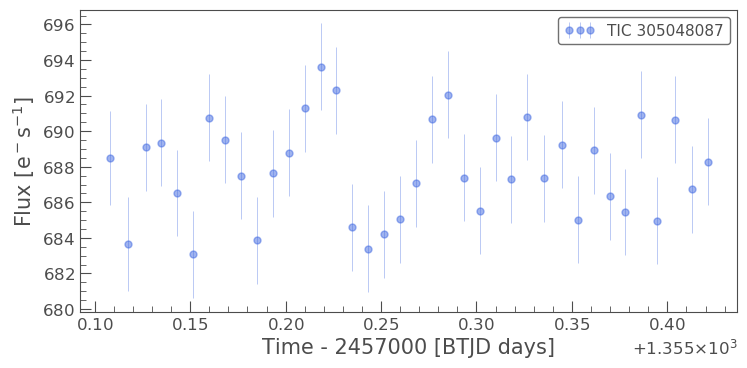

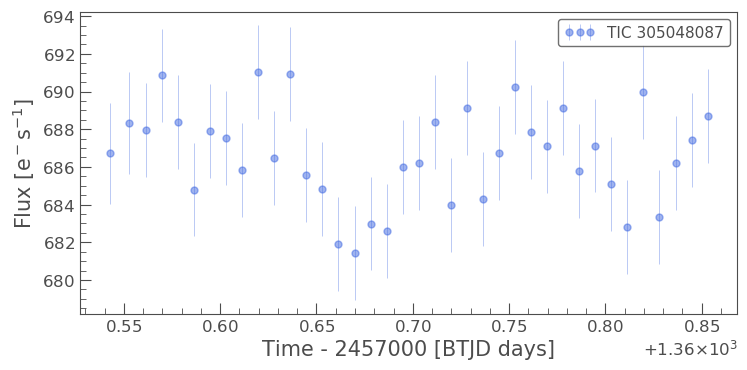

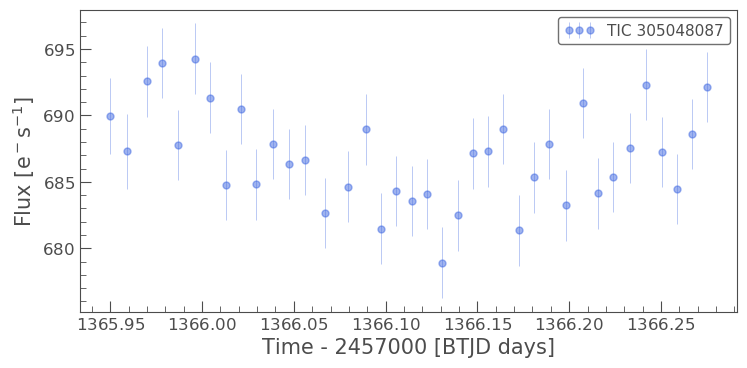

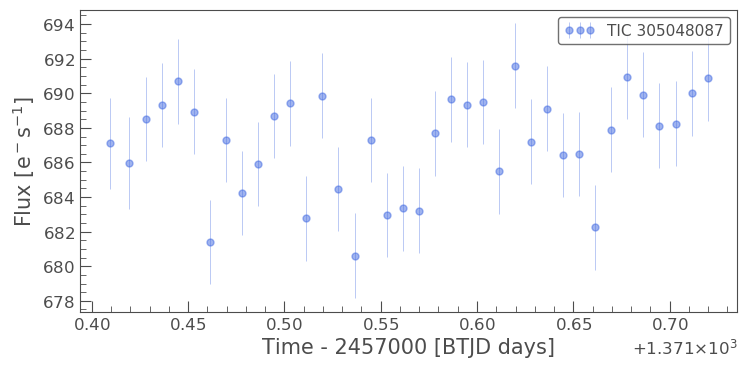

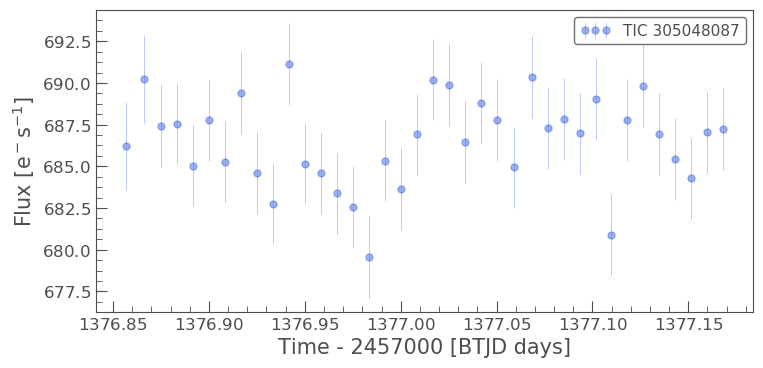

In [111]:
LC1 = LC_all[710:940].bin(binsize=6)
LC2 = LC_all[4560:4790].bin(binsize=6)
LC3 = LC_all[8380:8610].bin(binsize=6)
LC4 = LC_all[11210:11440].bin(binsize=6)
LC5 = LC_all[15070:15300].bin(binsize=6)

A1 = np.median(LC1.flux)
A2 = np.median(LC2.flux)
A3 = np.median(LC3.flux)
A4 = np.median(LC4.flux)
A5 = np.median(LC5.flux)

LC1.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)
LC2.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)
LC3.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)
LC4.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)
LC5.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False,zorder=-10)

In [69]:
LD_coeff = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met, filters = [BoxcarFilter('TESS',600,1000)])
LD = [LD_coeff[0][0],LD_coeff[0][1]]

In [122]:
# intialize some walkers
ndim, nwalkers, nsteps = 13, 150, 80000
burnin = int(0.2*nsteps)

# these are initial parameters
A1_init = np.random.uniform(A1-0.0005, A1+0.0005, nwalkers)
A2_init = np.random.uniform(A2-0.0005, A2+0.0005, nwalkers)
A3_init = np.random.uniform(A3-0.0005, A3+0.0005, nwalkers)
A4_init = np.random.uniform(A4-0.0005, A4+0.0005, nwalkers)
A5_init = np.random.uniform(A5-0.0005, A5+0.0005, nwalkers)

t01_init = np.random.uniform(expected_t0_1-0.00005,expected_t0_1+0.00005, nwalkers)
t02_init = np.random.uniform(expected_t0_2-0.00005,expected_t0_2+0.00005, nwalkers)
t03_init = np.random.uniform(expected_t0_3-0.00005,expected_t0_3+0.00005, nwalkers)
t04_init = np.random.uniform(expected_t0_4-0.00005,expected_t0_4+0.00005, nwalkers)
t05_init = np.random.uniform(expected_t0_5-0.00005,expected_t0_5+0.00005, nwalkers)

Rp_init = np.random.uniform(planet_radius-0.001, planet_radius+0.001, nwalkers)
a_init = np.random.uniform(planet_a-0.005, planet_a+0.005, nwalkers)
i_init = np.random.uniform(planet_i-0.005, planet_i+0.005, nwalkers)

p0 = np.transpose([A1_init,A2_init,A3_init,A4_init,A5_init,
                   t01_init,t02_init,t03_init,t04_init,t05_init,
                   Rp_init, a_init, i_init])

theta = [A1,A2,A3,A4,A5,
         expected_t0_1,expected_t0_2,expected_t0_3,expected_t0_4,expected_t0_5,
         planet_radius,planet_a,planet_i]

In [123]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args = (LC1,LC2,LC3,LC4,LC5,
                                        planet_period,LD,
                                        planet_a))
result = sampler.run_mcmc(p0, nsteps)

In [124]:
static_params = planet_radius, planet_period, planet_a, planet_i, toi
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
A1_sam,A2_sam,A3_sam,A4_sam,A5_sam,t01_sam,t02_sam,t03_sam,t04_sam,t05_sam,Rp_sam,A_sam,Inc_sam = samples

sig1_A1 = np.percentile(A1_sam, [16., 50., 84.])
sig1_A2 = np.percentile(A2_sam, [16., 50., 84.])
sig1_A3 = np.percentile(A3_sam, [16., 50., 84.])
sig1_A4 = np.percentile(A4_sam, [16., 50., 84.])
sig1_A5 = np.percentile(A5_sam, [16., 50., 84.])
sig1_t01 = np.percentile(t01_sam, [16., 50., 84.])
sig1_t02 = np.percentile(t02_sam, [16., 50., 84.])
sig1_t03 = np.percentile(t03_sam, [16., 50., 84.])
sig1_t04 = np.percentile(t04_sam, [16., 50., 84.])
sig1_t05 = np.percentile(t05_sam, [16., 50., 84.])

sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_A = np.percentile(A_sam, [16., 50., 84.])
sig1_Inc = np.percentile(Inc_sam, [16., 50., 84.])

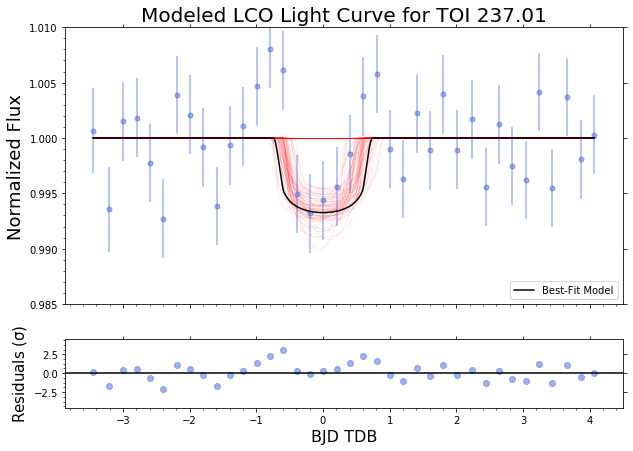

In [125]:
best_parameters = [sig1_A1[1],sig1_Rp[1],sig1_t01[1],sig1_A[1],sig1_Inc[1]]
#best_parameters = [sig1_A1[1],0.06,expected_t0_1,36,90]
light_curve(LC1,best_parameters,sampler,static_params,nsteps,tic_id,obs='first')

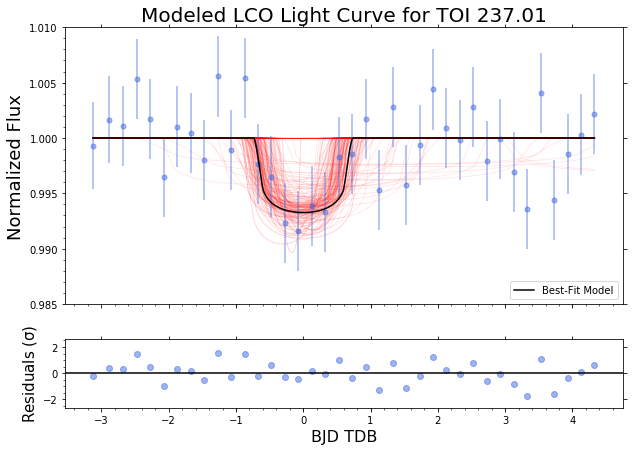

In [126]:
best_parameters = [sig1_A2[1],sig1_Rp[1],sig1_t02[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC2,best_parameters,sampler,static_params,nsteps,tic_id,obs='second')

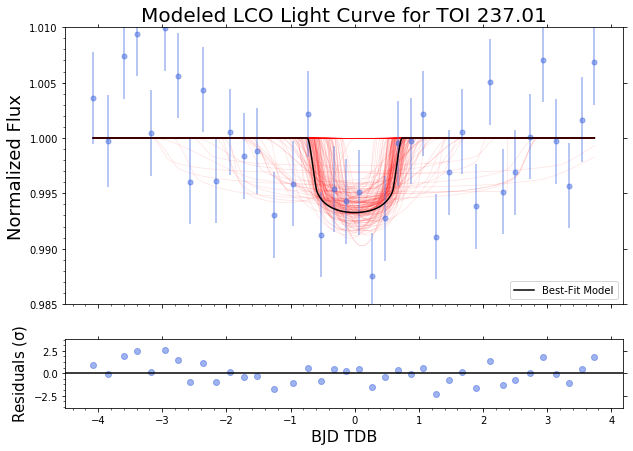

In [127]:
best_parameters = [sig1_A3[1],sig1_Rp[1],sig1_t03[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC3,best_parameters,sampler,static_params,nsteps,tic_id,obs='third')

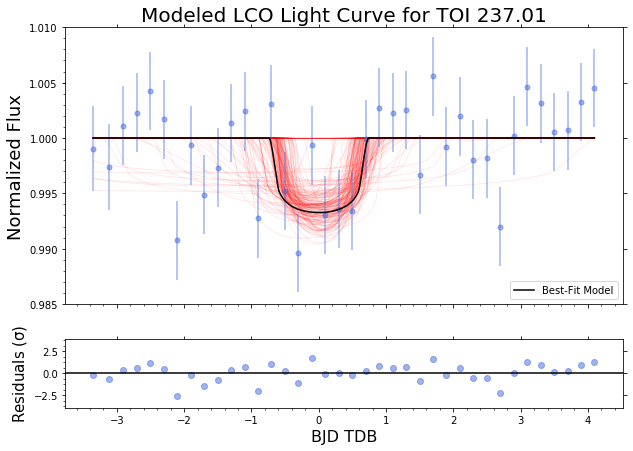

In [128]:
best_parameters = [sig1_A4[1],sig1_Rp[1],sig1_t04[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC4,best_parameters,sampler,static_params,nsteps,tic_id,obs='fourth')

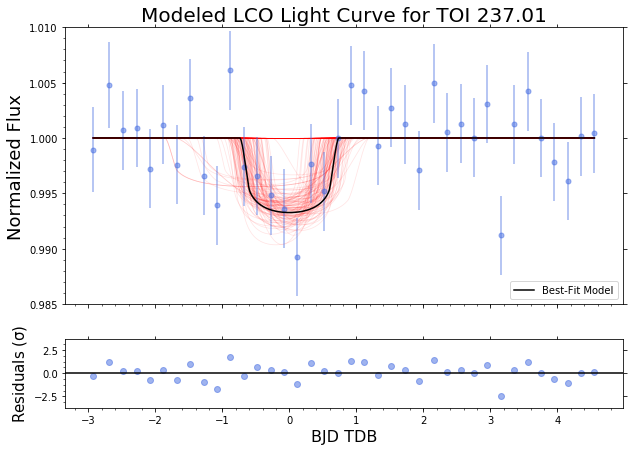

In [129]:
best_parameters = [sig1_A5[1],sig1_Rp[1],sig1_t05[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC5,best_parameters,sampler,static_params,nsteps,tic_id,obs='fifth')

In [130]:
print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp (R_E) = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168))

print('a/R* = {:.3f}'.format(sig1_A[1]),
      '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
      '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
      '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
      '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

print('Impact parameter (b) = {:.3f}'.format(np.cos((sig1_Inc[1])*np.pi/180)*sig1_A[1]))

print('Mid-Transit Time = {:.6f}'.format(sig1_t01[1]),
      '+ {:.6f}'.format(sig1_t01[2]-sig1_t01[1]),
      '- {:.6f}'.format(sig1_t01[1]-sig1_t01[0]))
print("Anticipated mid-transit time = {:.6f}".format(expected_t0_1))

print('Mid-Transit Time = {:.6f}'.format(sig1_t02[1]),
      '+ {:.6f}'.format(sig1_t02[2]-sig1_t02[1]),
      '- {:.6f}'.format(sig1_t02[1]-sig1_t02[0]))
print("Anticipated mid-transit time = {:.6f}".format(expected_t0_2))

print('Mid-Transit Time = {:.6f}'.format(sig1_t03[1]),
      '+ {:.6f}'.format(sig1_t03[2]-sig1_t03[1]),
      '- {:.6f}'.format(sig1_t03[1]-sig1_t03[0]))
print("Anticipated mid-transit time = {:.6f}".format(expected_t0_3))

print('Mid-Transit Time = {:.6f}'.format(sig1_t04[1]),
      '+ {:.6f}'.format(sig1_t04[2]-sig1_t04[1]),
      '- {:.6f}'.format(sig1_t04[1]-sig1_t04[0]))
print("Anticipated mid-transit time = {:.6f}".format(expected_t0_4))

print('Mid-Transit Time = {:.6f}'.format(sig1_t05[1]),
      '+ {:.6f}'.format(sig1_t05[2]-sig1_t05[1]),
      '- {:.6f}'.format(sig1_t05[1]-sig1_t05[0]))
print("Anticipated mid-transit time = {:.6f}".format(expected_t0_5))

Rp/R* = 0.0775 + 0.0312 - 0.0102
Rp (R_E) = 2.369 + 0.952 - 0.311
a/R* = 26.421 + 10.625 - 13.442
Inclination (Deg) = 88.848 + 0.886 - 2.427
Impact parameter (b) = 0.531
Mid-Transit Time = 1355.251473 + 339673175379750748160.000000 - 601507183788920274944.000000
Anticipated mid-transit time = 1355.249810
Mid-Transit Time = 1360.672772 + 0.010287 - 0.007263
Anticipated mid-transit time = 1360.685896
Mid-Transit Time = 1366.119558 + 7104.967759 - 1380.766827
Anticipated mid-transit time = 1366.121982
Mid-Transit Time = 1371.549019 + 0.006521 - 0.013363
Anticipated mid-transit time = 1371.558068
Mid-Transit Time = 1376.978490 + 50813936.730051 - 40856071.666686
Anticipated mid-transit time = 1376.994154


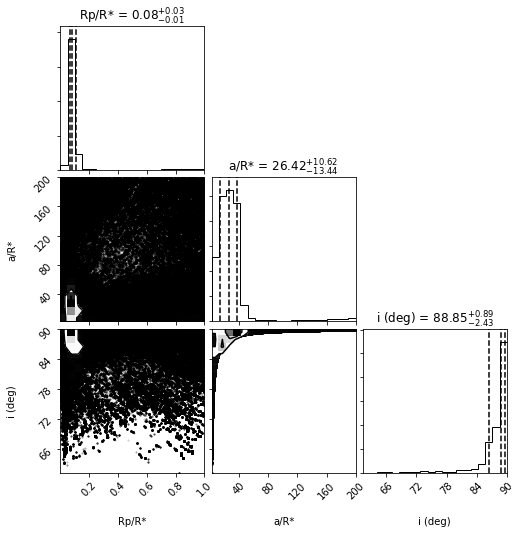

In [131]:
corner(samples)